In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import contractions
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# 1) Data Cleaning & Organization

In [2]:
tweets = pd.read_csv('covidvaccine.csv')

In [3]:
tweets.shape

(38459, 13)

In [4]:
# Checks out what type of data we're working with.

tweets.dtypes

user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
is_retweet            bool
dtype: object

In [5]:
# Checks out what columns have null values.

for col in tweets.columns:
    print(col, tweets[col].isnull().sum())

user_name 0
user_location 8443
user_description 2373
user_created 0
user_followers 0
user_friends 0
user_favourites 0
user_verified 0
date 0
text 0
hashtags 11621
source 1
is_retweet 0


In [6]:
# Filters data, so the results have are on topic to what this analysis is looking for.

search_Keywords = ['vaccine','vaccines', 'covid-19', 'covid', 'cure','cures', 'corona','virus' 'coronavirus', '#covidvaccine','#coronavaccine'
                  '#coronavirusvaccine','#covid-19','#vaccine','#covid19vaccine']
filter_tweets_by_keywords = tweets['text'].apply(lambda x: len(set(search_Keywords) - set(x.lower().split()))) < len(search_Keywords)
tweets_filtered = tweets[filter_tweets_by_keywords].reset_index()

In [7]:
# Deletes an unnecessary column for our analysis.

del tweets_filtered['is_retweet']

In [8]:
# Remove any contractions within the 'text' column.
# Then we recombine the elements within the 'no_contractions' column into a string.

tweets_filtered['no_contractions'] = tweets_filtered['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])
tweets_filtered['text_str'] = [' '.join(map(str, l)) for l in tweets_filtered['no_contractions']]
tweets_filtered.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,no_contractions,text_str
0,0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64,11,110,False,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and ...,['CovidVaccine'],Twitter Web App,"[Australia, to, Manufacture, Covid-19, Vaccine...",Australia to Manufacture Covid-19 Vaccine and ...
1,1,Shubham Gupta,NaN,I will tell about all experiences of my life f...,14-08-2020 16:42,1,17,0,False,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,"[#CoronavirusVaccine, #CoronaVaccine, #CovidVa...",#CoronavirusVaccine #CoronaVaccine #CovidVacci...
2,2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is ac...,14-12-2017 07:07,143,566,8,False,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\n...,NaN,Twitter Web App,"[Deaths, due, to, COVID-19, in, Affected, Coun...",Deaths due to COVID-19 in Affected Countries R...
3,7,AKisASocialisolationist wash yer damn hands,The Great Pacific Northwest,"Iconoclast, cat person, soccer fan, textile & ...",07-02-2015 07:24,2321,3236,264351,False,18-08-2020 12:30,"@MSNBC Well, let’s qualify that: would anyone ...",['CovidVaccine'],Twitter for iPhone,"[@MSNBC, Well,, let us, qualify, that:, would,...","@MSNBC Well, let us qualify that: would anyone..."
4,9,VUMC OAP,"Nashville, TN","Office of Advanced Practice, Vanderbilt Univer...",16-03-2017 20:22,282,96,788,False,18-08-2020 11:57,#DNA zooms up charts in 1st week; hear #vacci...,"['DNA', 'vaccines', 'pandemic', 'COVID19', 'Co...",Twitter Web App,"[#DNA, zooms, up, charts, in, 1st, week;, hear...",#DNA zooms up charts in 1st week; hear #vaccin...


In [9]:
# Tokenize the words in each of the tweets & lowercase all its elements.

tweets_filtered['tokenized'] = tweets_filtered['text_str'].apply(word_tokenize)
tweets_filtered['low_tokenized'] = tweets_filtered.text.str.lower()
tweets_filtered.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,no_contractions,text_str,tokenized,low_tokenized
0,0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64,11,110,False,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and ...,['CovidVaccine'],Twitter Web App,"[Australia, to, Manufacture, Covid-19, Vaccine...",Australia to Manufacture Covid-19 Vaccine and ...,"[Australia, to, Manufacture, Covid-19, Vaccine...",australia to manufacture covid-19 vaccine and ...
1,1,Shubham Gupta,NaN,I will tell about all experiences of my life f...,14-08-2020 16:42,1,17,0,False,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,"[#CoronavirusVaccine, #CoronaVaccine, #CovidVa...",#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"[#, CoronavirusVaccine, #, CoronaVaccine, #, C...",#coronavirusvaccine #coronavaccine #covidvacci...
2,2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is ac...,14-12-2017 07:07,143,566,8,False,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\n...,NaN,Twitter Web App,"[Deaths, due, to, COVID-19, in, Affected, Coun...",Deaths due to COVID-19 in Affected Countries R...,"[Deaths, due, to, COVID-19, in, Affected, Coun...",deaths due to covid-19 in affected countries\n...
3,7,AKisASocialisolationist wash yer damn hands,The Great Pacific Northwest,"Iconoclast, cat person, soccer fan, textile & ...",07-02-2015 07:24,2321,3236,264351,False,18-08-2020 12:30,"@MSNBC Well, let’s qualify that: would anyone ...",['CovidVaccine'],Twitter for iPhone,"[@MSNBC, Well,, let us, qualify, that:, would,...","@MSNBC Well, let us qualify that: would anyone...","[@, MSNBC, Well, ,, let, us, qualify, that, :,...","@msnbc well, let’s qualify that: would anyone ..."
4,9,VUMC OAP,"Nashville, TN","Office of Advanced Practice, Vanderbilt Univer...",16-03-2017 20:22,282,96,788,False,18-08-2020 11:57,#DNA zooms up charts in 1st week; hear #vacci...,"['DNA', 'vaccines', 'pandemic', 'COVID19', 'Co...",Twitter Web App,"[#DNA, zooms, up, charts, in, 1st, week;, hear...",#DNA zooms up charts in 1st week; hear #vaccin...,"[#, DNA, zooms, up, charts, in, 1st, week, ;, ...",#dna zooms up charts in 1st week; hear #vacci...


In [10]:
# Here we'll remove the punctiation and special characters.

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Removes @mentions
    text = re.sub(r'#', '', text)  # Removes hashtags
    text = re.sub(r'http[s]?://\S+', '', text)  # Removes website links
    text = re.sub(r'[^\w\s]+', '', text)  # Removes punctuation
    return text

tweets_filtered['clean_txt'] = tweets_filtered.low_tokenized.apply(clean_text)
tweets_filtered.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,no_contractions,text_str,tokenized,low_tokenized,clean_txt
0,0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64,11,110,False,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and ...,['CovidVaccine'],Twitter Web App,"[Australia, to, Manufacture, Covid-19, Vaccine...",Australia to Manufacture Covid-19 Vaccine and ...,"[Australia, to, Manufacture, Covid-19, Vaccine...",australia to manufacture covid-19 vaccine and ...,australia to manufacture covid19 vaccine and g...
1,1,Shubham Gupta,NaN,I will tell about all experiences of my life f...,14-08-2020 16:42,1,17,0,False,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,"[#CoronavirusVaccine, #CoronaVaccine, #CovidVa...",#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"[#, CoronavirusVaccine, #, CoronaVaccine, #, C...",#coronavirusvaccine #coronavaccine #covidvacci...,coronavirusvaccine coronavaccine covidvaccine ...
2,2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is ac...,14-12-2017 07:07,143,566,8,False,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\n...,NaN,Twitter Web App,"[Deaths, due, to, COVID-19, in, Affected, Coun...",Deaths due to COVID-19 in Affected Countries R...,"[Deaths, due, to, COVID-19, in, Affected, Coun...",deaths due to covid-19 in affected countries\n...,deaths due to covid19 in affected countries\nr...
3,7,AKisASocialisolationist wash yer damn hands,The Great Pacific Northwest,"Iconoclast, cat person, soccer fan, textile & ...",07-02-2015 07:24,2321,3236,264351,False,18-08-2020 12:30,"@MSNBC Well, let’s qualify that: would anyone ...",['CovidVaccine'],Twitter for iPhone,"[@MSNBC, Well,, let us, qualify, that:, would,...","@MSNBC Well, let us qualify that: would anyone...","[@, MSNBC, Well, ,, let, us, qualify, that, :,...","@msnbc well, let’s qualify that: would anyone ...",well lets qualify that would anyone of any pa...
4,9,VUMC OAP,"Nashville, TN","Office of Advanced Practice, Vanderbilt Univer...",16-03-2017 20:22,282,96,788,False,18-08-2020 11:57,#DNA zooms up charts in 1st week; hear #vacci...,"['DNA', 'vaccines', 'pandemic', 'COVID19', 'Co...",Twitter Web App,"[#DNA, zooms, up, charts, in, 1st, week;, hear...",#DNA zooms up charts in 1st week; hear #vaccin...,"[#, DNA, zooms, up, charts, in, 1st, week, ;, ...",#dna zooms up charts in 1st week; hear #vacci...,dna zooms up charts in 1st week hear vaccines...


In [11]:
# Removes any stopwords from out data.

stop_words = set(stopwords.words('english'))
tweets_filtered['stopwords_rem'] = tweets_filtered['clean_txt'].apply(lambda x: [word for word in x.split() if word not in stop_words])
tweets_filtered.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,no_contractions,text_str,tokenized,low_tokenized,clean_txt,stopwords_rem
0,0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64,11,110,False,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and ...,['CovidVaccine'],Twitter Web App,"[Australia, to, Manufacture, Covid-19, Vaccine...",Australia to Manufacture Covid-19 Vaccine and ...,"[Australia, to, Manufacture, Covid-19, Vaccine...",australia to manufacture covid-19 vaccine and ...,australia to manufacture covid19 vaccine and g...,"[australia, manufacture, covid19, vaccine, giv..."
1,1,Shubham Gupta,NaN,I will tell about all experiences of my life f...,14-08-2020 16:42,1,17,0,False,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,"[#CoronavirusVaccine, #CoronaVaccine, #CovidVa...",#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"[#, CoronavirusVaccine, #, CoronaVaccine, #, C...",#coronavirusvaccine #coronavaccine #covidvacci...,coronavirusvaccine coronavaccine covidvaccine ...,"[coronavirusvaccine, coronavaccine, covidvacci..."
2,2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is ac...,14-12-2017 07:07,143,566,8,False,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\n...,NaN,Twitter Web App,"[Deaths, due, to, COVID-19, in, Affected, Coun...",Deaths due to COVID-19 in Affected Countries R...,"[Deaths, due, to, COVID-19, in, Affected, Coun...",deaths due to covid-19 in affected countries\n...,deaths due to covid19 in affected countries\nr...,"[deaths, due, covid19, affected, countries, re..."
3,7,AKisASocialisolationist wash yer damn hands,The Great Pacific Northwest,"Iconoclast, cat person, soccer fan, textile & ...",07-02-2015 07:24,2321,3236,264351,False,18-08-2020 12:30,"@MSNBC Well, let’s qualify that: would anyone ...",['CovidVaccine'],Twitter for iPhone,"[@MSNBC, Well,, let us, qualify, that:, would,...","@MSNBC Well, let us qualify that: would anyone...","[@, MSNBC, Well, ,, let, us, qualify, that, :,...","@msnbc well, let’s qualify that: would anyone ...",well lets qualify that would anyone of any pa...,"[well, lets, qualify, would, anyone, party, ge..."
4,9,VUMC OAP,"Nashville, TN","Office of Advanced Practice, Vanderbilt Univer...",16-03-2017 20:22,282,96,788,False,18-08-2020 11:57,#DNA zooms up charts in 1st week; hear #vacci...,"['DNA', 'vaccines', 'pandemic', 'COVID19', 'Co...",Twitter Web App,"[#DNA, zooms, up, charts, in, 1st, week;, hear...",#DNA zooms up charts in 1st week; hear #vaccin...,"[#, DNA, zooms, up, charts, in, 1st, week, ;, ...",#dna zooms up charts in 1st week; hear #vacci...,dna zooms up charts in 1st week hear vaccines...,"[dna, zooms, charts, 1st, week, hear, vaccines..."


In [12]:
# Identifies each word's part of speech.

tweets_filtered['pos_tags'] = tweets_filtered['stopwords_rem'].apply(nltk.tag.pos_tag)
tweets_filtered.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,no_contractions,text_str,tokenized,low_tokenized,clean_txt,stopwords_rem,pos_tags
0,0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64,11,110,False,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and ...,['CovidVaccine'],Twitter Web App,"[Australia, to, Manufacture, Covid-19, Vaccine...",Australia to Manufacture Covid-19 Vaccine and ...,"[Australia, to, Manufacture, Covid-19, Vaccine...",australia to manufacture covid-19 vaccine and ...,australia to manufacture covid19 vaccine and g...,"[australia, manufacture, covid19, vaccine, giv...","[(australia, JJ), (manufacture, NN), (covid19,..."
1,1,Shubham Gupta,NaN,I will tell about all experiences of my life f...,14-08-2020 16:42,1,17,0,False,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,"[#CoronavirusVaccine, #CoronaVaccine, #CovidVa...",#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"[#, CoronavirusVaccine, #, CoronaVaccine, #, C...",#coronavirusvaccine #coronavaccine #covidvacci...,coronavirusvaccine coronavaccine covidvaccine ...,"[coronavirusvaccine, coronavaccine, covidvacci...","[(coronavirusvaccine, NN), (coronavaccine, NN)..."
2,2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is ac...,14-12-2017 07:07,143,566,8,False,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\n...,NaN,Twitter Web App,"[Deaths, due, to, COVID-19, in, Affected, Coun...",Deaths due to COVID-19 in Affected Countries R...,"[Deaths, due, to, COVID-19, in, Affected, Coun...",deaths due to covid-19 in affected countries\n...,deaths due to covid19 in affected countries\nr...,"[deaths, due, covid19, affected, countries, re...","[(deaths, NNS), (due, JJ), (covid19, RB), (aff..."
3,7,AKisASocialisolationist wash yer damn hands,The Great Pacific Northwest,"Iconoclast, cat person, soccer fan, textile & ...",07-02-2015 07:24,2321,3236,264351,False,18-08-2020 12:30,"@MSNBC Well, let’s qualify that: would anyone ...",['CovidVaccine'],Twitter for iPhone,"[@MSNBC, Well,, let us, qualify, that:, would,...","@MSNBC Well, let us qualify that: would anyone...","[@, MSNBC, Well, ,, let, us, qualify, that, :,...","@msnbc well, let’s qualify that: would anyone ...",well lets qualify that would anyone of any pa...,"[well, lets, qualify, would, anyone, party, ge...","[(well, RB), (lets, VBZ), (qualify, VB), (woul..."
4,9,VUMC OAP,"Nashville, TN","Office of Advanced Practice, Vanderbilt Univer...",16-03-2017 20:22,282,96,788,False,18-08-2020 11:57,#DNA zooms up charts in 1st week; hear #vacci...,"['DNA', 'vaccines', 'pandemic', 'COVID19', 'Co...",Twitter Web App,"[#DNA, zooms, up, charts, in, 1st, week;, hear...",#DNA zooms up charts in 1st week; hear #vaccin...,"[#, DNA, zooms, up, charts, in, 1st, week, ;, ...",#dna zooms up charts in 1st week; hear #vacci...,dna zooms up charts in 1st week hear vaccines...,"[dna, zooms, charts, 1st, week, hear, vaccines...","[(dna, NN), (zooms, NNS), (charts, NNS), (1st,..."


In [13]:
# This will concise the part of speech tags from above.

def wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
tweets_filtered['wordnet_pos'] = tweets_filtered['pos_tags'].apply(lambda x: [(word, wordnet_pos(pos_tag)) for (word, pos_tag) in x])
tweets_filtered.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,...,hashtags,source,no_contractions,text_str,tokenized,low_tokenized,clean_txt,stopwords_rem,pos_tags,wordnet_pos
0,0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64,11,110,False,18-08-2020 12:55,...,['CovidVaccine'],Twitter Web App,"[Australia, to, Manufacture, Covid-19, Vaccine...",Australia to Manufacture Covid-19 Vaccine and ...,"[Australia, to, Manufacture, Covid-19, Vaccine...",australia to manufacture covid-19 vaccine and ...,australia to manufacture covid19 vaccine and g...,"[australia, manufacture, covid19, vaccine, giv...","[(australia, JJ), (manufacture, NN), (covid19,...","[(australia, a), (manufacture, n), (covid19, n..."
1,1,Shubham Gupta,NaN,I will tell about all experiences of my life f...,14-08-2020 16:42,1,17,0,False,18-08-2020 12:55,...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,"[#CoronavirusVaccine, #CoronaVaccine, #CovidVa...",#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"[#, CoronavirusVaccine, #, CoronaVaccine, #, C...",#coronavirusvaccine #coronavaccine #covidvacci...,coronavirusvaccine coronavaccine covidvaccine ...,"[coronavirusvaccine, coronavaccine, covidvacci...","[(coronavirusvaccine, NN), (coronavaccine, NN)...","[(coronavirusvaccine, n), (coronavaccine, n), ..."
2,2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is ac...,14-12-2017 07:07,143,566,8,False,18-08-2020 12:46,...,NaN,Twitter Web App,"[Deaths, due, to, COVID-19, in, Affected, Coun...",Deaths due to COVID-19 in Affected Countries R...,"[Deaths, due, to, COVID-19, in, Affected, Coun...",deaths due to covid-19 in affected countries\n...,deaths due to covid19 in affected countries\nr...,"[deaths, due, covid19, affected, countries, re...","[(deaths, NNS), (due, JJ), (covid19, RB), (aff...","[(deaths, n), (due, a), (covid19, r), (affecte..."
3,7,AKisASocialisolationist wash yer damn hands,The Great Pacific Northwest,"Iconoclast, cat person, soccer fan, textile & ...",07-02-2015 07:24,2321,3236,264351,False,18-08-2020 12:30,...,['CovidVaccine'],Twitter for iPhone,"[@MSNBC, Well,, let us, qualify, that:, would,...","@MSNBC Well, let us qualify that: would anyone...","[@, MSNBC, Well, ,, let, us, qualify, that, :,...","@msnbc well, let’s qualify that: would anyone ...",well lets qualify that would anyone of any pa...,"[well, lets, qualify, would, anyone, party, ge...","[(well, RB), (lets, VBZ), (qualify, VB), (woul...","[(well, r), (lets, v), (qualify, v), (would, n..."
4,9,VUMC OAP,"Nashville, TN","Office of Advanced Practice, Vanderbilt Univer...",16-03-2017 20:22,282,96,788,False,18-08-2020 11:57,...,"['DNA', 'vaccines', 'pandemic', 'COVID19', 'Co...",Twitter Web App,"[#DNA, zooms, up, charts, in, 1st, week;, hear...",#DNA zooms up charts in 1st week; hear #vaccin...,"[#, DNA, zooms, up, charts, in, 1st, week, ;, ...",#dna zooms up charts in 1st week; hear #vacci...,dna zooms up charts in 1st week hear vaccines...,"[dna, zooms, charts, 1st, week, hear, vaccines...","[(dna, NN), (zooms, NNS), (charts, NNS), (1st,...","[(dna, n), (zooms, n), (charts, n), (1st, n), ..."


In [14]:
# Converts words into their root form. 

word_Lemm = WordNetLemmatizer()
tweets_filtered['lemmatized'] = tweets_filtered['wordnet_pos'].apply(lambda x: [word_Lemm.lemmatize(word, tag) for word, tag in x])
tweets_filtered.head()

,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,...,source,no_contractions,text_str,tokenized,low_tokenized,clean_txt,stopwords_rem,pos_tags,wordnet_pos,lemmatized
0,0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64,11,110,False,18-08-2020 12:55,...,Twitter Web App,"[Australia, to, Manufacture, Covid-19, Vaccine...",Australia to Manufacture Covid-19 Vaccine and ...,"[Australia, to, Manufacture, Covid-19, Vaccine...",australia to manufacture covid-19 vaccine and ...,australia to manufacture covid19 vaccine and g...,"[australia, manufacture, covid19, vaccine, giv...","[(australia, JJ), (manufacture, NN), (covid19,...","[(australia, a), (manufacture, n), (covid19, n...","[australia, manufacture, covid19, vaccine, giv..."
1,1,Shubham Gupta,NaN,I will tell about all experiences of my life f...,14-08-2020 16:42,1,17,0,False,18-08-2020 12:55,...,Twitter for Android,"[#CoronavirusVaccine, #CoronaVaccine, #CovidVa...",#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"[#, CoronavirusVaccine, #, CoronaVaccine, #, C...",#coronavirusvaccine #coronavaccine #covidvacci...,coronavirusvaccine coronavaccine covidvaccine ...,"[coronavirusvaccine, coronavaccine, covidvacci...","[(coronavirusvaccine, NN), (coronavaccine, NN)...","[(coronavirusvaccine, n), (coronavaccine, n), ...","[coronavirusvaccine, coronavaccine, covidvacci..."
2,2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is ac...,14-12-2017 07:07,143,566,8,False,18-08-2020 12:46,...,Twitter Web App,"[Deaths, due, to, COVID-19, in, Affected, Coun...",Deaths due to COVID-19 in Affected Countries R...,"[Deaths, due, to, COVID-19, in, Affected, Coun...",deaths due to covid-19 in affected countries\n...,deaths due to covid19 in affected countries\nr...,"[deaths, due, covid19, affected, countries, re...","[(deaths, NNS), (due, JJ), (covid19, RB), (aff...","[(deaths, n), (due, a), (covid19, r), (affecte...","[death, due, covid19, affected, country, read,..."
3,7,AKisASocialisolationist wash yer damn hands,The Great Pacific Northwest,"Iconoclast, cat person, soccer fan, textile & ...",07-02-2015 07:24,2321,3236,264351,False,18-08-2020 12:30,...,Twitter for iPhone,"[@MSNBC, Well,, let us, qualify, that:, would,...","@MSNBC Well, let us qualify that: would anyone...","[@, MSNBC, Well, ,, let, us, qualify, that, :,...","@msnbc well, let’s qualify that: would anyone ...",well lets qualify that would anyone of any pa...,"[well, lets, qualify, would, anyone, party, ge...","[(well, RB), (lets, VBZ), (qualify, VB), (woul...","[(well, r), (lets, v), (qualify, v), (would, n...","[well, let, qualify, would, anyone, party, get..."
4,9,VUMC OAP,"Nashville, TN","Office of Advanced Practice, Vanderbilt Univer...",16-03-2017 20:22,282,96,788,False,18-08-2020 11:57,...,Twitter Web App,"[#DNA, zooms, up, charts, in, 1st, week;, hear...",#DNA zooms up charts in 1st week; hear #vaccin...,"[#, DNA, zooms, up, charts, in, 1st, week, ;, ...",#dna zooms up charts in 1st week; hear #vacci...,dna zooms up charts in 1st week hear vaccines...,"[dna, zooms, charts, 1st, week, hear, vaccines...","[(dna, NN), (zooms, NNS), (charts, NNS), (1st,...","[(dna, n), (zooms, n), (charts, n), (1st, n), ...","[dna, zoom, chart, 1st, week, hear, vaccine, e..."


# 2) Exploratory Data & Sentiment Analysis

In [15]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from wordcloud import WordCloud
from PIL import Image
import datetime as dt
import seaborn as sns
from matplotlib.pyplot import figure
import time

In [16]:
# Make a new Dataframe wit the 'lemmatized' column from tweets_filtered
# Convert the enire column from a list to string
# Drop duplicates

df = pd.DataFrame(tweets_filtered[['date', 'clean_txt', 'lemmatized']])
df['lemmatized'] = [' '.join(map(str, l)) for l in df['lemmatized']]
df.drop_duplicates(inplace = True)
df['date'] = pd.to_datetime(df['date'])

In [17]:
# Transform column from string to a list

df['clean_txt'] = df['clean_txt'].str.split()

In [18]:
# Create a new column with the word count of each tweet

df['word_count'] = df.clean_txt.apply(lambda x: len(x))

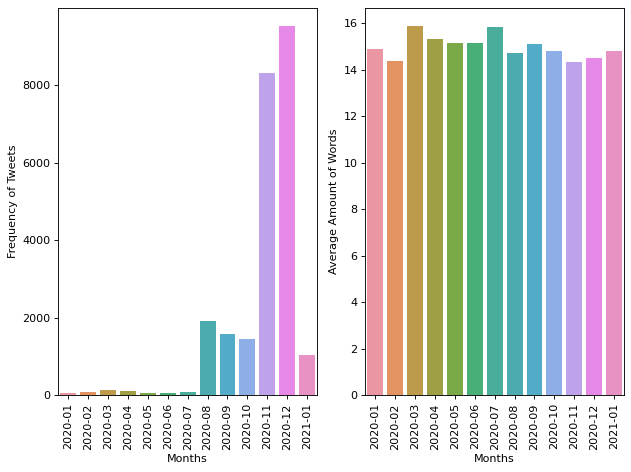

In [19]:
# Lets check out the frequency of the tweets per month as well as average amount of words of tweets per month

count_plt = df.groupby(pd.Grouper(key= 'date', freq = '1M')).count()
mean_plt = df.groupby(pd.Grouper(key= 'date', freq = '1M')).mean()
x_ticks = pd.to_datetime(pd.date_range(start='1/1/2020', periods = 13, freq='1M')).strftime('%Y-%m')

_ = figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.subplot(1,2,1)
_ = plt.xlabel('Months')
_ = plt.xticks(rotation = 90)
_ = plt.ylabel('Frequency of Tweets')
_ = sns.barplot(x = x_ticks, y = count_plt.word_count.values)

_ = plt.subplot(1,2,2)
_ = plt.ylabel('Average Amount of Words')
_ = plt.xlabel('Months')
_ = plt.xticks(rotation = 90)
_ = sns.barplot(x = x_ticks, y = mean_plt.word_count.values)
_ = plt.tight_layout()

In [20]:
# Calculates negative, positive, neutral & compound values

df[['polarity', 'subjectivity']] = df['lemmatized'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in df['lemmatized'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row) #provides score values for the variables directly below
    neg = score['neg']  
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        df.loc[index, 'sentiment'] = 'negative' #Assigns overall sentiment of post based on polarity score
    elif pos > neg:
        df.loc[index, 'sentiment'] = 'positive'
    else:
        df.loc[index, 'sentiment'] = 'neutral'
    df.loc[index, 'neg'] = neg
    df.loc[index, 'neu'] = neu
    df.loc[index, 'pos'] = pos
    df.loc[index, 'compound'] = comp


In [21]:
pd.set_option('display.max_colwidth', None)
df.sample(5)

,date,clean_txt,lemmatized,word_count,polarity,subjectivity,sentiment,neg,neu,pos,compound
3361,2020-08-09 22:52:00,"[astrazeneca, shares, plunge, as, covid, vaccine, study, put, on, hold, due, to, adverse, reaction, covidvaccine]",astrazeneca share plunge covid vaccine study put hold due adverse reaction covidvaccine,15,-0.125000,0.375000,negative,0.17,0.680,0.150,-0.0772
5858,2020-09-26 21:30:01,"[report, uk, chief, scientific, adviser, owns, 600000, worth, of, shares, in, covid, vaccine, manufacturer]",report uk chief scientific adviser own 600000 worth share covid vaccine manufacturer,14,0.450000,0.550000,positive,0.00,0.709,0.291,0.4767
8497,2020-11-09 14:51:41,"[finally, a, step, in, a, good, direction, pfizer, biontech, vaccine, covid19, covidvaccine]",finally step good direction pfizer biontech vaccine covid19 covidvaccine,12,0.350000,0.800000,positive,0.00,0.734,0.266,0.4404
23042,2020-12-27 14:03:43,"[my, daughter, got, her, covidvaccine, this, morninghappy, new, year]",daughter get covidvaccine morninghappy new year,9,0.136364,0.454545,neutral,0.00,1.000,0.000,0.0000
16147,2020-12-31 10:45:00,"[covidvaccine, pakistan, minister, for, science, amp, tech, said, that, the, vaccine, will, be, provided, freeof]",covidvaccine pakistan minister science amp tech say vaccine provide freeof,15,0.000000,0.000000,neutral,0.00,1.000,0.000,0.0000


In [22]:
# Split data into 3 groups:

df_pos = df[df['sentiment'] == 'positive']
df_neg = df[df['sentiment'] == 'negative']
df_neu = df[df['sentiment'] == 'neutral']
df_pos.head()

,date,clean_txt,lemmatized,word_count,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2020-08-18 12:55:00,"[australia, to, manufacture, covid19, vaccine, and, give, it, to, the, citizens, for, free, of, cost, afp, quotes, prime, minister, covidvaccine]",australia manufacture covid19 vaccine give citizen free cost afp quote prime minister covidvaccine,20,0.4,0.80,positive,0.0,0.784,0.216,0.5106
1,2020-08-18 12:55:00,"[coronavirusvaccine, coronavaccine, covidvaccine, australia, is, doing, very, good]",coronavirusvaccine coronavaccine covidvaccine australia good,8,0.7,0.60,positive,0.0,0.580,0.420,0.4404
3,2020-08-18 12:30:00,"[well, lets, qualify, that, would, anyone, of, any, party, get, a, vaccine, rushed, out, and, minimally, tested, coming, from, russia, covidvaccine]",well let qualify would anyone party get vaccine rush minimally test come russia covidvaccine,21,-0.1,0.60,positive,0.0,0.714,0.286,0.5859
6,2020-08-18 11:02:00,"[great, news, s, vaccine, has, entered, phase, 3, trial, read, more, pharmaceutical]",great news vaccine enter phase 3 trial read pharmaceutical,12,0.8,0.75,positive,0.0,0.631,0.369,0.6249
12,2020-08-18 08:52:00,"[search, chennai, corona, affected, street, or, area, wise, covidvaccine, covid19chennai, covid19]",search chennai corona affect street area wise covidvaccine covid19chennai covid19,11,0.7,0.90,positive,0.0,0.744,0.256,0.4767


In [23]:
# Creates a function that counts the total values in each group and provides the overall percentage of each group

def count_values_in_column(data, feature):
    total = data.loc[:, feature].value_counts(dropna= False)
    percentage = round(data.loc[:, feature].value_counts(dropna= False, normalize= True) * 100, 2)
    return pd.concat([total,percentage], axis= 1, keys= ['Total','Percentage'])

In [24]:
count_values_in_column(df, 'sentiment')

,Total,Percentage
positive,10574,43.22
neutral,9377,38.32
negative,4517,18.46


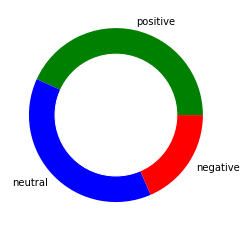

In [25]:
# Creates a pie chart for the percentage of each sentiment type

piechart = count_values_in_column(df , 'sentiment')
names = piechart.index
size = piechart['Percentage']
 
# Creates a circle for the center of the plot

my_circle=plt.Circle((0, 0), 0.7, color= 'white')
plt.pie(size, labels= names, colors= ['green', 'blue', 'red'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

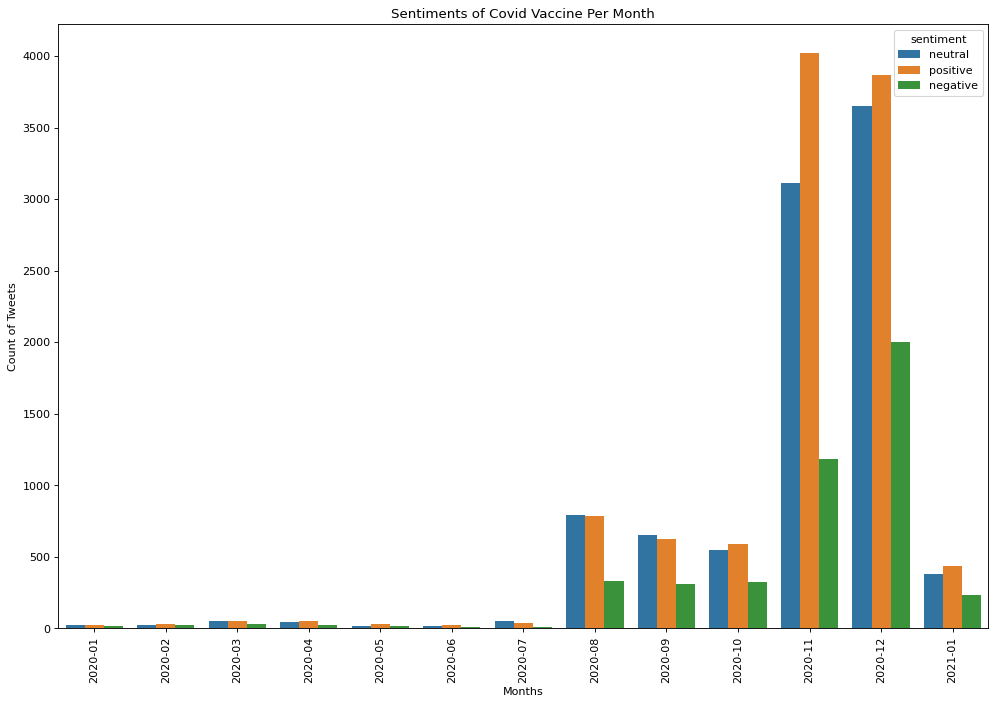

In [26]:
# Lets create a bar plot to distinguish the amount of tweets based on sentiments by month

sent_count = pd.DataFrame(df.groupby(pd.Grouper(key= 'date', freq = '1M'))['sentiment'].value_counts()).rename(columns =\
                                                                                                       {'sentiment': 'count'})
sent_count.reset_index(inplace= True)
sent_count.date = sent_count['date'].dt.to_period('M')

_ = figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
_ = sns.barplot(x= 'date' , y= 'count', hue= 'sentiment', data= sent_count)
_ = plt.xlabel('Months')
_ = plt.ylabel('Count of Tweets')
_ = plt.title('Sentiments of Covid Vaccine Per Month')
_ = plt.xticks(rotation = 90)
_ = plt.show()

In [27]:
# Creates a function to construct the word cloud

def create_wordcloud(text):
    wc = WordCloud(background_color= 'white', max_words= 2500, repeat= True)
    wc.generate(str(text))
    wc.to_file('wc.png')
    print('Word Cloud Saved Successfully')
    path= 'wc.png'
    display(Image.open(path))

Word Cloud Saved Successfully


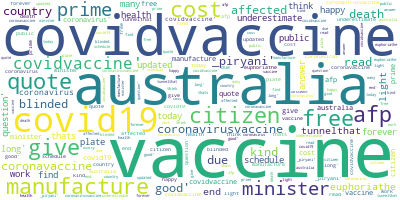

In [28]:
# Display wordcloud of the overall data

create_wordcloud(df['lemmatized'].values)

Word Cloud Saved Successfully


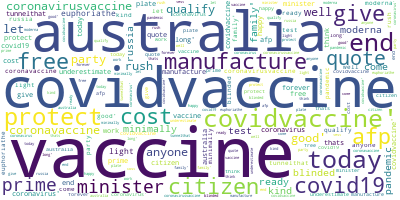

In [29]:
# Display wordcloud of the positive sentiments

create_wordcloud(df_pos['lemmatized'].values)

Word Cloud Saved Successfully


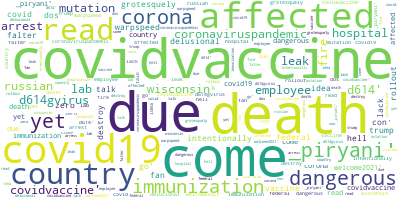

In [30]:
# Display wordcloud of the negative sentiments

create_wordcloud(df_neg['lemmatized'].values)

In [31]:
# Density of tweets

df['text_length'] = df['lemmatized'].apply(len)
df['filtered_word_count'] = df['lemmatized'].apply(lambda x: len(str(x).split()))
round(pd.DataFrame(df.groupby('sentiment').text_length.mean()), 2)

,text_length
sentiment,
negative,70.93
neutral,66.62
positive,70.04


In [32]:
# Word count for each sentiment type

round(pd.DataFrame(df.groupby('sentiment').filtered_word_count.mean()), 2)

,filtered_word_count
sentiment,
negative,9.84
neutral,8.81
positive,9.65


In [33]:
# Apply CountVectorizer to convert each word into a feature

countVectorizer = CountVectorizer() 
countVector = countVectorizer.fit_transform(df['lemmatized'])

In [34]:
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())

In [36]:
# Finds the most frequently used word and rename columns

count = pd.DataFrame(count_vect_df.sum())
count_df = count.sort_values(by= 0, ascending= False)
count_df.reset_index(inplace= True)
count_df = count_df.rename(columns = {'index': 'word', 0 : 'frequency'})

In [37]:
count_df.head()

,word,frequency
0,covidvaccine,17671
1,vaccine,11260
2,covid19,6843
3,covid,3335
4,get,2957


In [38]:
# Remove any rows containing website links (it's completely useless in our analysis)

count_df = count_df[~count_df.word.str.contains('https')]
count_df.reset_index(drop= True, inplace= True)
count_df.head()

,word,frequency
0,covidvaccine,17671
1,vaccine,11260
2,covid19,6843
3,covid,3335
4,get,2957


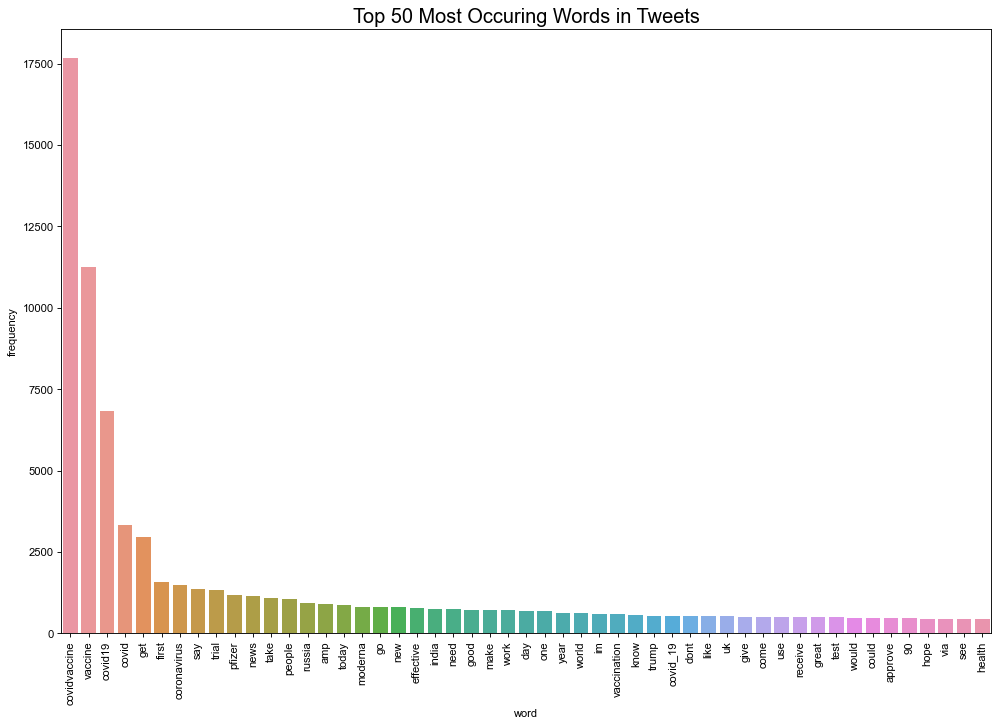

In [40]:
# Graph the words and their frequency

_ = figure( figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
_ = sns.barplot(x = count_df.iloc[0: 51, 0], y = count_df.frequency)
_ = plt.xticks(rotation= 90)
_ = sns.set(font_scale=1.5)
_ = plt.title('Top 50 Most Occuring Words in Tweets')

# 3) Build A Machine Learning Model

In [48]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [42]:
# Encode the sentiment of positive, neutral and negative into values

le = LabelEncoder()
df['Label_enc'] = le.fit_transform(df['sentiment'])
df.head()

,date,clean_txt,lemmatized,word_count,polarity,subjectivity,sentiment,neg,neu,pos,compound,text_length,filtered_word_count,Label_enc
0,2020-08-18 12:55:00,"[australia, to, manufacture, covid19, vaccine, and, give, it, to, the, citizens, for, free, of, cost, afp, quotes, prime, minister, covidvaccine]",australia manufacture covid19 vaccine give citizen free cost afp quote prime minister covidvaccine,20,0.400,0.800,positive,0.000,0.784,0.216,0.5106,98,13,2
1,2020-08-18 12:55:00,"[coronavirusvaccine, coronavaccine, covidvaccine, australia, is, doing, very, good]",coronavirusvaccine coronavaccine covidvaccine australia good,8,0.700,0.600,positive,0.000,0.580,0.420,0.4404,60,5,2
2,2020-08-18 12:46:00,"[deaths, due, to, covid19, in, affected, countries, read, more, _piryani]",death due covid19 affected country read _piryani,10,-0.125,0.375,negative,0.524,0.476,0.000,-0.6705,48,7,0
3,2020-08-18 12:30:00,"[well, lets, qualify, that, would, anyone, of, any, party, get, a, vaccine, rushed, out, and, minimally, tested, coming, from, russia, covidvaccine]",well let qualify would anyone party get vaccine rush minimally test come russia covidvaccine,21,-0.100,0.600,positive,0.000,0.714,0.286,0.5859,92,14,2
4,2020-08-18 11:57:00,"[dna, zooms, up, charts, in, 1st, week, hear, vaccines, episode, pandemic, covid19, covidvaccine]",dna zoom chart 1st week hear vaccine episode pandemic covid19 covidvaccine,13,0.000,0.000,neutral,0.000,1.000,0.000,0.0000,74,11,1


In [134]:
# Select features for train and test

X = df['lemmatized']
y = df['Label_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=124, stratify=y)

In [180]:
# Transform text data into weighted numerical values
# Apply Bernoulli Naive Bayes variant
# Find best_accuracy based on baseline parameters

model_vect = TfidfVectorizer()
tfidf_train = model_vect.fit_transform(X_train)
tfidf_test = model_vect.transform(X_test)
nb = BernoulliNB(alpha= 0.5)
nb.fit(tfidf_train, y_train)

best_accuracy = cross_val_score(nb, tfidf_test, y_test, cv= 5, scoring='accuracy').max()
print("Accuracy:",best_accuracy)

Accuracy: 0.7027579162410623


In [155]:
# Set up GridSearch to hypertune parameters 

cv_method = StratifiedKFold(n_splits = 5)
param_NB = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}   # Values for Laplace smoothing
gs_NB = GridSearchCV(estimator=BernoulliNB(), 
                      param_grid= param_NB, 
                      cv= cv_method,
                      scoring='accuracy', 
                      return_train_score= True)

In [156]:
# Fit our gridsearch to our train set

gs_NB.fit(tfidf_train, y_train)
grid_df = pd.DataFrame(gs_NB.cv_results_)

In [177]:
# Predict values from test set

y_pred = gs_NB.predict(tfidf_test)
y_test_array = np.asarray(y_test)

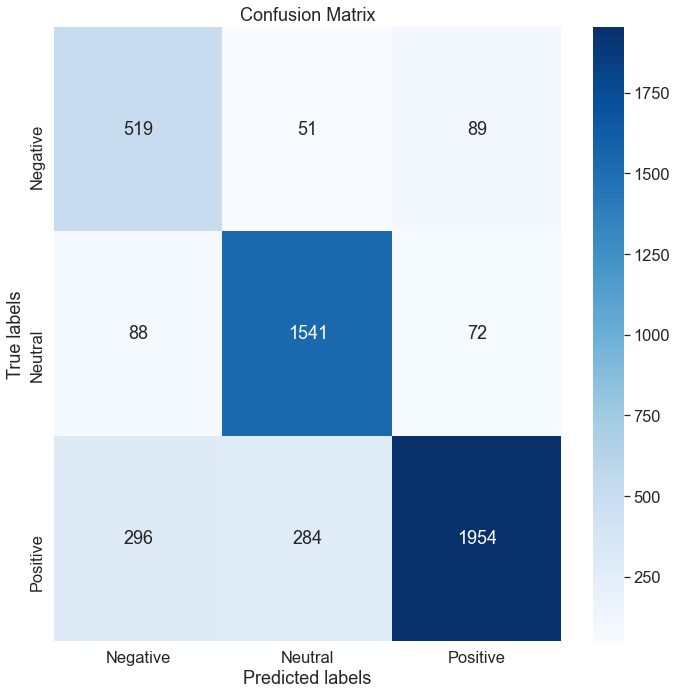

In [187]:
#Create heatmap of confusion matrix of placement of each tweets with regards to sentiment

cf_matrix = confusion_matrix(y_pred, y_test_array)
fig, ax= plt.subplots(figsize= (10,10))
sns.heatmap(cf_matrix, annot=True, ax = ax, cmap='Blues',fmt='');

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']);

In [179]:
# Precision and recall

print(classification_report(y_pred, y_test_array))

              precision    recall  f1-score   support

           0       0.57      0.79      0.66       659
           1       0.82      0.91      0.86      1701
           2       0.92      0.77      0.84      2534

    accuracy                           0.82      4894
   macro avg       0.77      0.82      0.79      4894
weighted avg       0.84      0.82      0.82      4894



In [157]:
# Best score provided by our Gridsearch

gs_NB.best_score_

0.8064272666936845

In [160]:
# Show the different iteration of alpha and its mean score

grid_df[['param_alpha', 'mean_test_score']]

,param_alpha,mean_test_score
0,0.1,0.789875
1,0.2,0.798151
2,0.3,0.803924
3,0.4,0.806121
4,0.5,0.806427
5,0.6,0.804128
6,0.7,0.799531
7,0.8,0.795290
8,0.9,0.789977
9,1,0.783999


In [149]:
# How well our model fitted to the data?

gs_NB.score(tfidf_train, y_train)

0.9339940737713294

In [151]:
gs_NB.score(tfidf_test, y_test)

0.8201879852881079

In [ ]:
#x = df.loc[df['sentiment'] != 'neutral', ['sentiment', 'text_word_count']] (going to plot frequence of positive and negative)

In [ ]:
#Self note: Fix Pie char(add percentage?)

In [ ]:
#Questions: Correct tfidf implementation (words are not tokenized), Difference between best_score_ and score (x_test, y_test)
# Was BernoulliNB best method (classifies with discrete values, but keep reading about binary)
# When I put the best params from the gridsearch into the cross_val the accuracy is different, why?
# Confusion matrix labeled correctly?